# 图片增广(image augmentation)

定义一个辅助函数，给定输入图片`img`的增广方法`aug`，它会运行多次并画出结果。

Populating the interactive namespace from numpy and matplotlib


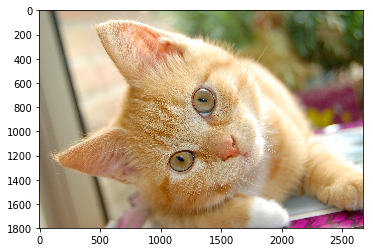

In [1]:
%pylab inline
from mxnet import image

img = image.imdecode(open('E:/Data/Raw/cat.jpg', 'rb').read())
plt.imshow(img.asnumpy())

In [2]:
from mxnet import nd

import utils

def apply(img, aug, n=3):
    # 转成float，一是因为aug需要float类型数据来方便做变化。
    # 二是这里会有一次copy操作，因为有些aug直接通过改写输入
    #（而不是新建输出）获取性能的提升
    X = [aug(img.astype('float32')) for _ in range(n*n)]
    # 有些aug不保证输入是合法值，所以做一次clip
    # 显示浮点图片时imshow要求输入在[0,1]之间
    Y = nd.stack(*X).clip(0,255)/255
    utils.show_images(Y, n, n, figsize=(8,8))

## 变形
水平方向翻转图片是最早也是最广泛使用的一种增广。

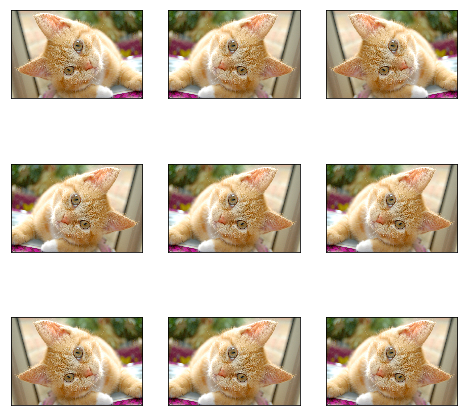

In [3]:
# 以.5的概率做翻转
aug = image.HorizontalFlipAug(.5)
apply(img, aug)

注意到随机截取一般会缩小输入的形状。如果原始输入图片过小，导致没有太多空间进行随机裁剪，通常做法是先将其放大的足够大的尺寸。所以如果你的原始图片足够大，建议不要事先将它们裁到网络需要的大小。

In [ ]:
# 随机裁剪一个块 1000 x 1000 的区域
aug = image.RandomCropAug([7000,5000])
apply(img, aug)

我们也可以随机裁剪一块随机大小的区域

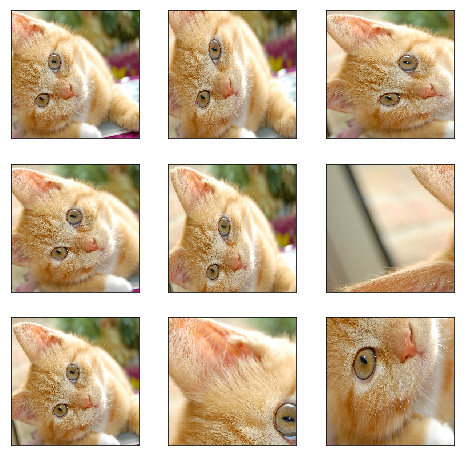

In [39]:
# 随机裁剪，要求保留至少0.1的区域，随机长宽比在.5和2之间。
# 最后将结果resize到200x200
aug = image.RandomSizedCropAug((224, 224), .1, (.5,2))
apply(img, aug)

## 颜色变化

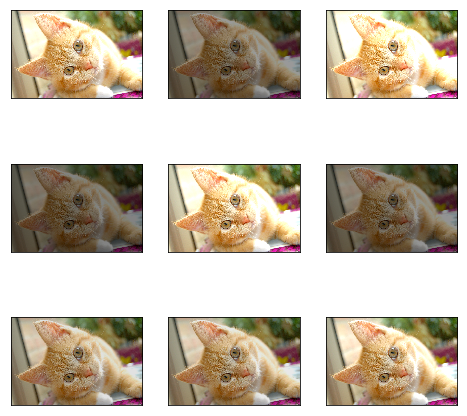

In [14]:
# 随机将亮度增加或者减小在0-50%间的一个量
aug = image.BrightnessJitterAug(.5)
apply(img, aug)

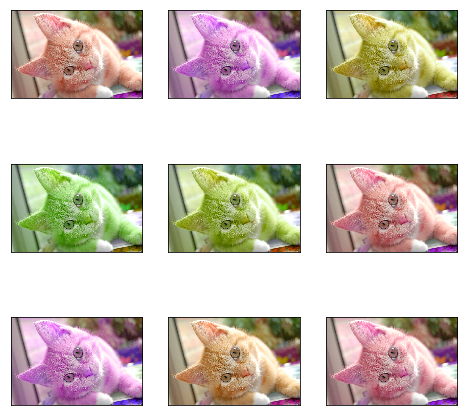

In [15]:
# 随机色调变化
aug = image.HueJitterAug(.5)
apply(img, aug)

## 使用

In [4]:
def apply_aug_list(img, augs):
    for f in augs:
        img = f(img)
    return img

train_augs = [
    image.HorizontalFlipAug(.5),
    image.RandomCropAug((28,28))
]

test_augs = [
    image.CenterCropAug((28,28))
]

In [5]:
from mxnet import gluon
from mxnet import nd
import sys
sys.path.append('..')
import utils

def get_transform(augs):
    def transform(data, label):
        # data: sample x height x width x channel
        # label: sample
        data = data.astype('float32')
        if augs is not None:
            # apply to each sample one-by-one and then stack
            data = nd.stack(*[
                apply_aug_list(d, augs) for d in data])
        data = nd.transpose(data, (0,3,1,2))
        return data, label.astype('float32')
    return transform

def get_data(batch_size, train_augs, test_augs=None):
    cifar10_train = gluon.data.vision.CIFAR10(
        train=True, transform=get_transform(train_augs))
    cifar10_test = gluon.data.vision.CIFAR10(
        train=False, transform=get_transform(test_augs))
    train_data = utils.DataLoader(
        cifar10_train, batch_size, shuffle=True)
    test_data = utils.DataLoader(
        cifar10_test, batch_size, shuffle=False)
    return (train_data, test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

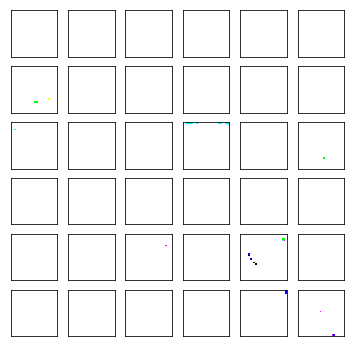

In [21]:
train_data, _ = get_data(36, train_augs)
for imgs, _ in train_data:
    break
utils.show_images(imgs.transpose((0,2,3,1)), 6, 6)

In [22]:
imgs.shape

(36, 3, 28, 28)

In [23]:
from mxnet import init

def train(train_augs, test_augs, learning_rate=.1):
    batch_size = 128
    num_epochs = 10
    ctx = utils.try_all_gpus()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    train_data, test_data = get_data(
        batch_size, train_augs, test_augs)
    net = utils.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': learning_rate})
    utils.train(
        train_data, test_data, net, loss, trainer, ctx, num_epochs)

### 使用增广：

In [24]:
train(train_augs, test_augs)

Start training on  [gpu(0)]
Epoch 0. Loss: 1.492, Train acc 0.47, Test acc 0.52, Time 102.2 sec
Epoch 1. Loss: 1.063, Train acc 0.62, Test acc 0.66, Time 104.4 sec
Epoch 2. Loss: 0.883, Train acc 0.69, Test acc 0.69, Time 93.9 sec
Epoch 3. Loss: 0.765, Train acc 0.73, Test acc 0.73, Time 102.9 sec
Epoch 4. Loss: 0.687, Train acc 0.76, Test acc 0.75, Time 96.8 sec
Epoch 5. Loss: 0.622, Train acc 0.78, Test acc 0.75, Time 91.1 sec
Epoch 6. Loss: 0.580, Train acc 0.80, Test acc 0.76, Time 54.1 sec
Epoch 7. Loss: 0.537, Train acc 0.81, Test acc 0.78, Time 53.5 sec
Epoch 8. Loss: 0.500, Train acc 0.83, Test acc 0.78, Time 53.5 sec
Epoch 9. Loss: 0.471, Train acc 0.83, Test acc 0.78, Time 55.0 sec
